## 1. DataSet import

In [1]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from prepare_datasets import *

X, y , feature_names , categorical_features, continuous_features, actionable_features= get_and_prepare_german_dataset()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 2. Model

In [3]:
# Taken from https://github.com/dylan-slack/manipulating-cfes/blob/main/train_models.py
# wanted to use this the same model as in the paper
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, return_logit=False):
        out = self.fc1(x)
        out = self.tanh1(out)
        out = self.fc2(out)
        out = self.tanh2(out)
        out = self.fc3(out)
        out = self.tanh3(out)
        out = self.fc4(out)
        return out


In [4]:
model = NeuralNetwork(X.shape[1], 200, 2)

## 3. Training

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [6]:
from sklearn.metrics import f1_score, accuracy_score

epochs = 600
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
model.to(device)

train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss = loss_fn(y_logits, y_train.long())

    f1_score_training = f1_score(
        y_true=y_train.cpu().detach().numpy(),
        y_pred=y_pred.cpu().detach().numpy()
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss = loss_fn(test_logits, y_test.long())

        f1_score_test = f1_score(
            y_true=y_test.cpu().detach().numpy(),
            y_pred=test_pred.cpu().detach().numpy()
        )

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    train_f1_scores.append(f1_score_training)
    test_f1_scores.append(f1_score_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, F1-Training: {f1_score_training:.2f}% | Test loss: {test_loss:.5f}, F1-Testing: {f1_score_test:.2f}%")

Epoch: 0 | Loss: 0.66293, F1-Training: 0.82% | Test loss: 0.64132, F1-Testing: 0.83%
Epoch: 100 | Loss: 0.58798, F1-Training: 0.82% | Test loss: 0.60628, F1-Testing: 0.83%
Epoch: 200 | Loss: 0.57623, F1-Training: 0.82% | Test loss: 0.60809, F1-Testing: 0.84%
Epoch: 300 | Loss: 0.56109, F1-Training: 0.82% | Test loss: 0.60010, F1-Testing: 0.83%
Epoch: 400 | Loss: 0.55088, F1-Training: 0.82% | Test loss: 0.59784, F1-Testing: 0.83%
Epoch: 500 | Loss: 0.53521, F1-Training: 0.83% | Test loss: 0.58117, F1-Testing: 0.83%


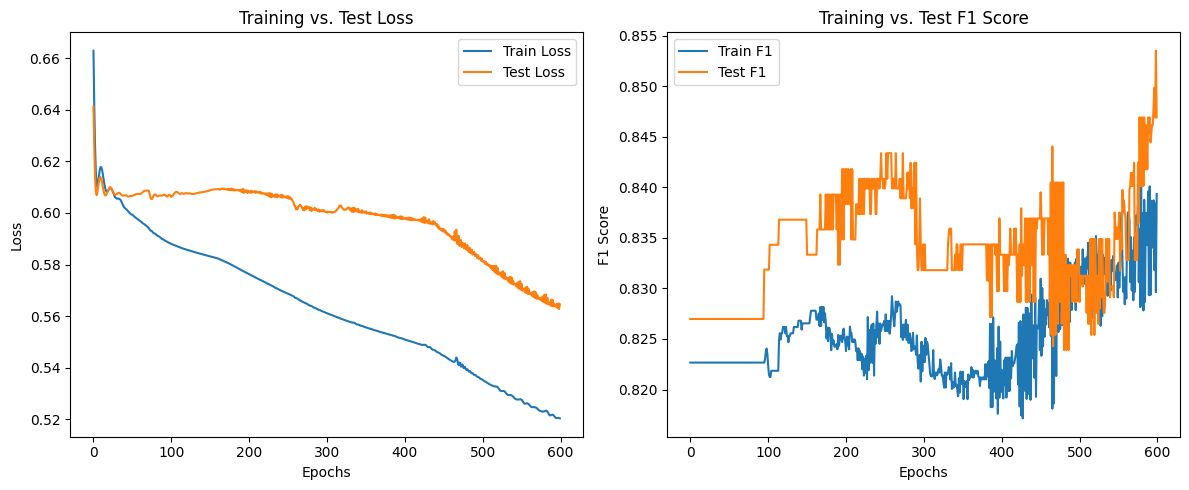

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Test Loss")
plt.legend()

# Plot F1 Score
plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label="Train F1")
plt.plot(test_f1_scores, label="Test F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training vs. Test F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

## 4. Counterfactual generation:
### 4.1. of one Instance

In [8]:
import dice_ml

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=continuous_features,
    categorical_features=categorical_features,
    outcome_name='target'
)

In [9]:
class PyTorchModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, x):
        self.model.eval()
        with torch.no_grad():
            x = x.values
            x = x.astype(np.float64)
            x_tensor = torch.FloatTensor(x)
            logits = self.model(x_tensor)
            probabilities = torch.softmax(logits, dim=1)  
            return probabilities.cpu().numpy()

dice_model = dice_ml.Model(
    model=PyTorchModelWrapper(model),
    backend="sklearn",
    model_type='classifier'
)

exp = dice_ml.Dice(
    dice_data,
    dice_model,
    method="genetic"
)


In [10]:

query_instance = X[11:12]
query_df = pd.DataFrame(query_instance, columns=feature_names)


#  generate counterfactuals
dice_exp = exp.generate_counterfactuals(
    query_df,
    total_CFs=1,
    desired_class="opposite",
    features_to_vary = actionable_features
)

print("\nCounterfactuals:")
dice_exp.visualize_as_dataframe(show_only_changes=True)


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Counterfactuals:
Query instance (original outcome : 0)


,Gender,ForeignWorker,Single,Age,LoanDuration,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,...,OtherLoansAtBank,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,target
0,1.0,0.0,0.0,24.0,48.0,4308.0,3.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0



Diverse Counterfactual set (new outcome: 1.0)


,Gender,ForeignWorker,Single,Age,LoanDuration,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,...,OtherLoansAtBank,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,target
0,-,-,-,-,18.0,-,-,-,-,-,...,-,-,-,1.0,0.0,-,0.0,-,-,1.0


### 4.2. calculating L1 Distance

In [11]:
# get counterfactuals as list
cf_list = dice_exp.cf_examples_list[0].final_cfs_df.values.tolist()

# Convert query_instance to tensor
if isinstance(query_instance, np.ndarray):
    query_instance = torch.from_numpy(query_instance).float()

for cf in cf_list:
    # Convert cf to tensor
    if isinstance(cf, list):
        cf = np.array(cf)
    if isinstance(cf, np.ndarray):
        cf = torch.from_numpy(cf).float()

    cf_features = cf[:-1]  # all features except the last one which is the target
    query_features = query_instance.squeeze()

    with torch.no_grad():
        # Calculate L1 distance between feature vectors
        distance = torch.norm(query_features - cf_features, p=1)
        print(f"L1 distance between query and counterfactual: {distance.item()}")

L1 distance between query and counterfactual: 106.0


## 4.3. Calculating the mean value of all L1 Distances of negatively classified instances

In [12]:
from Helper_functions import *

X_positive, X_negative, pos_indices, neg_indices = split_by_classification(model, X)


In [13]:
query_df = pd.DataFrame(X_negative.cpu().numpy(), columns=feature_names)

dice_exp = exp.generate_counterfactuals(
    query_df,
    total_CFs=1,
    desired_class="opposite",
    features_to_vary=actionable_features
)

100%|██████████| 177/177 [02:05<00:00,  1.41it/s]


In [14]:
l1_distances = []
for i in range(len(X_negative)):
    original = X_negative[i]
    cf_df = dice_exp.cf_examples_list[i].final_cfs_df#
    if cf_df is None or cf_df.empty:
        continue
    cf_values = cf_df[feature_names].values
    cf_tensor = torch.from_numpy(cf_values).float().to(device)
    distance = torch.norm(original - cf_tensor, p=1).item()
    l1_distances.append(distance)

# Compute mean L1 distance
mean_l1 = np.mean(l1_distances)
print(f"Mean L1 distance for negatively classified data using DiCE: {mean_l1:.2f}")

Mean L1 distance for negatively classified data using DiCE: 2107.70


## 5. Saving the model

In [15]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


## Calculating the initial approximation of recourse

In [16]:
loaded_model = NeuralNetwork(X.shape[1], 200, 2)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

X_positive, X_negative, pos_indices, neg_indices = split_by_classification(loaded_model, X)

y_logits_negative = loaded_model(X_negative)
abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
recourse_Approximation = torch.mean(abs_differences)


print(f"initial Recourse Approximation: {recourse_Approximation:.2f}")

initial Recourse Approximation: 0.52


## 5. Approximating the Cost of Recourse:


## 5. Modifying the Cost function:

the cost function has this formula

$$  L (X) = BinaryCrossEntropy(D {\scriptstyle train}) -  \frac{\lambda}{|D {\scriptstyle negative}|} \cdot \sum_{x \in D {\scriptstyle negative}} C(x)  $$


with C(x) is an approximation of the Cost of Recourse set to be
$$ C(x) = |G{\scriptstyle class 1} - G{\scriptstyle class 2} |$$

G being the logit of that specific class and the approximation being the difference of the logits

Calculating the counterfactuals for the negatively classified instances mutiple times during the training loop can be very costly. That justifies the use of use of an approximation

In [17]:
from sklearn.metrics import accuracy_score

lamda = 0.1
epochs = 1000

loaded_model = NeuralNetwork(X.shape[1], 200, 2)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

initial_accuracy = accuracy_score(y, torch.argmax(loaded_model(X), dim=1))
print(f"Initial Accuracy: {initial_accuracy:.2f}")

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

X_train_positive, X_train_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_train)

X_test_positive, X_test_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_test)

loss_fn_1 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=0.0001)
accuracies = []
for epoch in range(epochs):
    loaded_model.train()

    y_logits = loaded_model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss_1 = loss_fn_1(y_logits, y_train.long())

    y_logits_negative = loaded_model(X_train_negative)

    abs_differences = torch.abs (y_logits_negative[:, 0] - y_logits_negative[:, 1])
    loss_2 = torch.mean(abs_differences)
    loss = loss_1 - lamda * loss_2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loaded_model.eval()
    with torch.inference_mode():
        test_logits = loaded_model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss_1 = loss_fn_1(test_logits, y_test.long())

        y_logits_negative = loaded_model(X_test_negative)

        abs_differences = torch.abs (y_logits_negative[:, 0] - y_logits_negative[:, 1])
        test_loss_2 = torch.mean(abs_differences)

        test_loss = test_loss_1 - lamda * test_loss_2

        accuracy = accuracy_score(y_test, torch.argmax(loaded_model(X_test), dim=1))

    if epoch % 10 == 0:
        X_train_positive, X_train_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_train)

        X_test_positive, X_test_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}| Test loss: {test_loss:.5f}| Accuracy: {accuracy:.5f}")

Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.47045| Test loss: 0.52980| Accuracy: 0.62000
Epoch: 100 | Loss: 0.45509| Test loss: 0.49250| Accuracy: 0.72333
Epoch: 200 | Loss: 0.44746| Test loss: 0.48905| Accuracy: 0.74000
Epoch: 300 | Loss: 0.43421| Test loss: 0.47094| Accuracy: 0.72333
Epoch: 400 | Loss: 0.42095| Test loss: 0.46660| Accuracy: 0.72667
Epoch: 500 | Loss: 0.39942| Test loss: 0.46055| Accuracy: 0.71667
Epoch: 600 | Loss: 0.39184| Test loss: 0.46343| Accuracy: 0.72333
Epoch: 700 | Loss: 0.40398| Test loss: 0.46301| Accuracy: 0.74667
Epoch: 800 | Loss: 0.36997| Test loss: 0.46848| Accuracy: 0.75000
Epoch: 900 | Loss: 0.33040| Test loss: 0.43407| Accuracy: 0.74667


## Testing for different Lamdas


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

lambdas = np.linspace(0.01, 1, 40)
epochs = 250
mean_accuracies = []
mean_recourse_approximations = []
mean_recourses = []

for lamda in lambdas:
    print(f"\nTraining for lambda = {lamda:.3f}")

    loaded_model = NeuralNetwork(X.shape[1], 200, 2)
    loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

    initial_accuracy = accuracy_score(y, torch.argmax(loaded_model(X), dim=1))
    print(f"Initial Accuracy: {initial_accuracy:.2f}")

    X_train_positive, X_train_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_train)

    X_test_positive, X_test_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_test)

    loss_fn_1 = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(loaded_model.parameters(), lr=0.0001)

    epoch_accuracies = []
    epoch_recourse = []

    for epoch in range(epochs):
        loaded_model.train()

        y_logits = loaded_model(X_train)
        loss_1 = loss_fn_1(y_logits, y_train.long())

        y_logits_negative = loaded_model(X_train_negative)
        abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
        loss_2 = torch.mean(abs_differences)

        loss = loss_1 - lamda * loss_2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loaded_model.eval()
        with torch.inference_mode():
            test_logits = loaded_model(X_test)
            test_loss_1 = loss_fn_1(test_logits, y_test.long())

            y_logits_negative = loaded_model(X_test_negative)
            abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
            test_loss_2 = torch.mean(abs_differences)

            test_loss = test_loss_1 - lamda * test_loss_2

            accuracy = accuracy_score(y_test, torch.argmax(test_logits, dim=1))
            epoch_accuracies.append(accuracy)
            if not torch.isnan(test_loss_2):
                epoch_recourse.append(test_loss_2.item())

        if epoch % 10 == 0:

            X_train_positive, X_train_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_train)
            X_test_positive, X_test_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_test)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f} | Accuracy: {accuracy:.5f} | Recourse loss: {test_loss_2:.5f}")

    mean_accuracy = np.mean(epoch_accuracies)
    mean_recourse = np.mean(epoch_recourse)

    mean_accuracies.append(mean_accuracy)
    mean_recourse_approximations.append(mean_recourse)

    # calculating the Recourse for all
    X_positive, X_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X)

    dice_model = dice_ml.Model(
        model=PyTorchModelWrapper(loaded_model),
        backend="sklearn",
        model_type='classifier'
    )

    exp = dice_ml.Dice(
        dice_data,
        dice_model,
        method="genetic"
    )

    query_df = pd.DataFrame(X_negative.cpu().numpy(), columns=feature_names)

    dice_exp = exp.generate_counterfactuals(
        query_df,
        total_CFs=1,
        desired_class="opposite",
        features_to_vary=actionable_features
    )

    l1_distances = []
    for i in range(len(X_negative)):
        original = X_negative[i]
        cf_df = dice_exp.cf_examples_list[i].final_cfs_df
        if cf_df is None or cf_df.empty:
            continue
        cf_values = cf_df[feature_names].values
        cf_tensor = torch.from_numpy(cf_values).float().to(device)
        distance = torch.norm(original - cf_tensor, p=1).item()
        l1_distances.append(distance)

    # Compute mean L1 distance
    mean_l1 = np.mean(l1_distances)

    print(f"Mean L1 distance for negatively classified data using DiCE: {mean_l1:.2f}")
    mean_recourses.append(mean_l1)

    print(f"Lambda = {lamda:.3f} | Mean Accuracy: {mean_accuracy:.4f} | Mean Recourse Approximations: {mean_recourse:.4f}")






Training for lambda = 0.010
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.51661 | Test loss: 0.61747 | Accuracy: 0.72000 | Recourse loss: 0.61583
Epoch: 100 | Loss: 0.51049 | Test loss: 0.55101 | Accuracy: 0.75667 | Recourse loss: 0.64269
Epoch: 200 | Loss: 0.50440 | Test loss: 0.55115 | Accuracy: 0.76000 | Recourse loss: 0.76373


100%|██████████| 187/187 [02:47<00:00,  1.12it/s]


Mean L1 distance for negatively classified data using DiCE: 1838.78
Lambda = 0.010 | Mean Accuracy: 0.7575 | Mean Recourse Approximations: 0.6901

Training for lambda = 0.035
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.50359 | Test loss: 0.60470 | Accuracy: 0.63333 | Recourse loss: 1.47449
Epoch: 100 | Loss: 0.49739 | Test loss: 0.53202 | Accuracy: 0.74667 | Recourse loss: 0.78914
Epoch: 200 | Loss: 0.49067 | Test loss: 0.53204 | Accuracy: 0.76000 | Recourse loss: 0.91873


100%|██████████| 242/242 [02:08<00:00,  1.89it/s]


Mean L1 distance for negatively classified data using DiCE: 1707.48
Lambda = 0.035 | Mean Accuracy: 0.7506 | Mean Recourse Approximations: 0.8415

Training for lambda = 0.061
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.49057 | Test loss: 0.58927 | Accuracy: 0.61667 | Recourse loss: 1.51933
Epoch: 100 | Loss: 0.48145 | Test loss: 0.52428 | Accuracy: 0.74333 | Recourse loss: 1.03000
Epoch: 200 | Loss: 0.47238 | Test loss: 0.51897 | Accuracy: 0.74000 | Recourse loss: 1.14241


100%|██████████| 276/276 [04:43<00:00,  1.03s/it]


Mean L1 distance for negatively classified data using DiCE: 2069.95
Lambda = 0.061 | Mean Accuracy: 0.7379 | Mean Recourse Approximations: 1.0925

Training for lambda = 0.086
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.47756 | Test loss: 0.55078 | Accuracy: 0.62000 | Recourse loss: 1.51924
Epoch: 100 | Loss: 0.46570 | Test loss: 0.49547 | Accuracy: 0.72667 | Recourse loss: 1.09151
Epoch: 200 | Loss: 0.45500 | Test loss: 0.47545 | Accuracy: 0.74000 | Recourse loss: 1.34068


100%|██████████| 319/319 [04:57<00:00,  1.07it/s]


Mean L1 distance for negatively classified data using DiCE: 2390.55
Lambda = 0.086 | Mean Accuracy: 0.7312 | Mean Recourse Approximations: 1.2411

Training for lambda = 0.112
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.46454 | Test loss: 0.51226 | Accuracy: 0.62000 | Recourse loss: 1.52006
Epoch: 100 | Loss: 0.45809 | Test loss: 0.50702 | Accuracy: 0.73667 | Recourse loss: 0.87238
Epoch: 200 | Loss: 0.44283 | Test loss: 0.48276 | Accuracy: 0.74333 | Recourse loss: 1.17790


100%|██████████| 356/356 [04:20<00:00,  1.37it/s]


Mean L1 distance for negatively classified data using DiCE: 1972.22
Lambda = 0.112 | Mean Accuracy: 0.7070 | Mean Recourse Approximations: 1.5223

Training for lambda = 0.137
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.45152 | Test loss: 0.47351 | Accuracy: 0.62000 | Recourse loss: 1.52046
Epoch: 100 | Loss: 0.28432 | Test loss: 0.36413 | Accuracy: 0.56333 | Recourse loss: 3.38405
Epoch: 200 | Loss: 0.30025 | Test loss: 0.33936 | Accuracy: 0.54667 | Recourse loss: 3.91314


100%|██████████| 125/125 [00:52<00:00,  2.37it/s]


Mean L1 distance for negatively classified data using DiCE: 180.30
Lambda = 0.137 | Mean Accuracy: 0.6661 | Mean Recourse Approximations: 1.6791

Training for lambda = 0.162
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.43850 | Test loss: 0.43528 | Accuracy: 0.62000 | Recourse loss: 1.52106
Epoch: 100 | Loss: 0.37250 | Test loss: 0.39326 | Accuracy: 0.64667 | Recourse loss: 2.36290
Epoch: 200 | Loss: 0.18135 | Test loss: 0.13860 | Accuracy: 0.64667 | Recourse loss: 3.58878


100%|██████████| 464/464 [05:23<00:00,  1.44it/s]


Mean L1 distance for negatively classified data using DiCE: 1578.41
Lambda = 0.162 | Mean Accuracy: 0.6672 | Mean Recourse Approximations: 1.8968

Training for lambda = 0.188
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.42548 | Test loss: 0.39666 | Accuracy: 0.62000 | Recourse loss: 1.52102
Epoch: 100 | Loss: 0.38156 | Test loss: 0.41533 | Accuracy: 0.72000 | Recourse loss: 1.83473
Epoch: 200 | Loss: 0.42012 | Test loss: 0.40689 | Accuracy: 0.71000 | Recourse loss: 1.83294


100%|██████████| 442/442 [05:15<00:00,  1.40it/s]


Mean L1 distance for negatively classified data using DiCE: 1827.49
Lambda = 0.188 | Mean Accuracy: 0.6629 | Mean Recourse Approximations: 2.2718

Training for lambda = 0.213
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.41246 | Test loss: 0.35807 | Accuracy: 0.62000 | Recourse loss: 1.52094
Epoch: 100 | Loss: 0.36295 | Test loss: 0.35461 | Accuracy: 0.71000 | Recourse loss: 1.49506
Epoch: 200 | Loss: 0.10888 | Test loss: -0.02031 | Accuracy: 0.59667 | Recourse loss: 4.78011


100%|██████████| 208/208 [03:57<00:00,  1.14s/it]


Mean L1 distance for negatively classified data using DiCE: 1630.82
Lambda = 0.213 | Mean Accuracy: 0.6447 | Mean Recourse Approximations: 2.3916

Training for lambda = 0.238
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.39944 | Test loss: 0.31946 | Accuracy: 0.62000 | Recourse loss: 1.52092
Epoch: 100 | Loss: 0.24333 | Test loss: 0.21480 | Accuracy: 0.72667 | Recourse loss: 2.20603
Epoch: 200 | Loss: -0.05545 | Test loss: -0.18960 | Accuracy: 0.48333 | Recourse loss: 6.48176


100%|██████████| 428/428 [03:45<00:00,  1.90it/s]


Mean L1 distance for negatively classified data using DiCE: 1569.68
Lambda = 0.238 | Mean Accuracy: 0.6335 | Mean Recourse Approximations: 2.6011

Training for lambda = 0.264
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.38642 | Test loss: 0.28087 | Accuracy: 0.62000 | Recourse loss: 1.52088
Epoch: 100 | Loss: -0.07681 | Test loss: -0.18208 | Accuracy: 0.37000 | Recourse loss: 6.24722
Epoch: 200 | Loss: 0.31343 | Test loss: 0.26084 | Accuracy: 0.71333 | Recourse loss: 2.17331


100%|██████████| 378/378 [03:44<00:00,  1.69it/s]


Mean L1 distance for negatively classified data using DiCE: 2164.19
Lambda = 0.264 | Mean Accuracy: 0.6217 | Mean Recourse Approximations: 2.7635

Training for lambda = 0.289
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.37340 | Test loss: 0.24226 | Accuracy: 0.62000 | Recourse loss: 1.52088
Epoch: 100 | Loss: 0.11413 | Test loss: 0.09031 | Accuracy: 0.74000 | Recourse loss: 2.53134
Epoch: 200 | Loss: -0.29114 | Test loss: -0.45307 | Accuracy: 0.42000 | Recourse loss: 7.59616


100%|██████████| 320/320 [03:35<00:00,  1.48it/s]


Mean L1 distance for negatively classified data using DiCE: 636.79
Lambda = 0.289 | Mean Accuracy: 0.6118 | Mean Recourse Approximations: 2.9488

Training for lambda = 0.315
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.36038 | Test loss: 0.20366 | Accuracy: 0.62000 | Recourse loss: 1.52087
Epoch: 100 | Loss: 0.30035 | Test loss: 0.30176 | Accuracy: 0.63333 | Recourse loss: 1.90596
Epoch: 200 | Loss: -1.16747 | Test loss: -1.14227 | Accuracy: 0.36333 | Recourse loss: 11.19561


100%|██████████| 774/774 [06:56<00:00,  1.86it/s]  


Mean L1 distance for negatively classified data using DiCE: 2610.50
Lambda = 0.315 | Mean Accuracy: 0.6027 | Mean Recourse Approximations: 3.5304

Training for lambda = 0.340
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.34736 | Test loss: 0.16489 | Accuracy: 0.62000 | Recourse loss: 1.52106
Epoch: 100 | Loss: -0.35149 | Test loss: -0.36885 | Accuracy: 0.48333 | Recourse loss: 6.79802
Epoch: 200 | Loss: -0.03233 | Test loss: -0.10126 | Accuracy: 0.71667 | Recourse loss: 3.17984


100%|██████████| 705/705 [08:19<00:00,  1.41it/s]  


Mean L1 distance for negatively classified data using DiCE: 2071.68
Lambda = 0.340 | Mean Accuracy: 0.5942 | Mean Recourse Approximations: 3.7642

Training for lambda = 0.365
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.33434 | Test loss: 0.12631 | Accuracy: 0.62000 | Recourse loss: 1.52101
Epoch: 100 | Loss: -0.75312 | Test loss: -0.78583 | Accuracy: 0.53667 | Recourse loss: 7.37144
Epoch: 200 | Loss: -0.64100 | Test loss: -0.83492 | Accuracy: 0.53000 | Recourse loss: 8.36183


100%|██████████| 372/372 [03:21<00:00,  1.84it/s]


Mean L1 distance for negatively classified data using DiCE: 1825.77
Lambda = 0.365 | Mean Accuracy: 0.5777 | Mean Recourse Approximations: 4.0690

Training for lambda = 0.391
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.32132 | Test loss: 0.08772 | Accuracy: 0.62000 | Recourse loss: 1.52096
Epoch: 100 | Loss: -0.39324 | Test loss: -0.44281 | Accuracy: 0.50000 | Recourse loss: 6.65941
Epoch: 200 | Loss: 0.04766 | Test loss: -0.07189 | Accuracy: 0.66333 | Recourse loss: 3.31849


100%|██████████| 409/409 [02:58<00:00,  2.29it/s]


Mean L1 distance for negatively classified data using DiCE: 2104.63
Lambda = 0.391 | Mean Accuracy: 0.5685 | Mean Recourse Approximations: 4.2156

Training for lambda = 0.416
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.30830 | Test loss: 0.04911 | Accuracy: 0.62000 | Recourse loss: 1.52096
Epoch: 100 | Loss: -0.35938 | Test loss: -0.41790 | Accuracy: 0.55333 | Recourse loss: 5.74259
Epoch: 200 | Loss: 0.02078 | Test loss: -0.12010 | Accuracy: 0.66333 | Recourse loss: 3.66933


100%|██████████| 753/753 [07:34<00:00,  1.66it/s]  


Mean L1 distance for negatively classified data using DiCE: 1863.16
Lambda = 0.416 | Mean Accuracy: 0.5606 | Mean Recourse Approximations: 5.1106

Training for lambda = 0.442
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.29529 | Test loss: 0.01050 | Accuracy: 0.62000 | Recourse loss: 1.52098
Epoch: 100 | Loss: -0.03809 | Test loss: 0.00293 | Accuracy: 0.61333 | Recourse loss: 2.93556
Epoch: 200 | Loss: -0.14072 | Test loss: -0.32029 | Accuracy: 0.54333 | Recourse loss: 7.93114


100%|██████████| 303/303 [02:10<00:00,  2.33it/s]


Mean L1 distance for negatively classified data using DiCE: 619.31
Lambda = 0.442 | Mean Accuracy: 0.5501 | Mean Recourse Approximations: 5.1966

Training for lambda = 0.467
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.28227 | Test loss: -0.02812 | Accuracy: 0.62000 | Recourse loss: 1.52099
Epoch: 100 | Loss: 0.04452 | Test loss: 0.04471 | Accuracy: 0.48333 | Recourse loss: 5.90138
Epoch: 200 | Loss: -0.68063 | Test loss: -0.88870 | Accuracy: 0.72667 | Recourse loss: 4.75070


100%|██████████| 762/762 [07:56<00:00,  1.60it/s]  


Mean L1 distance for negatively classified data using DiCE: 2410.53
Lambda = 0.467 | Mean Accuracy: 0.5363 | Mean Recourse Approximations: 5.6646

Training for lambda = 0.492
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.26925 | Test loss: -0.06673 | Accuracy: 0.62000 | Recourse loss: 1.52099
Epoch: 100 | Loss: 0.05256 | Test loss: -0.00961 | Accuracy: 0.46667 | Recourse loss: 6.20503
Epoch: 200 | Loss: -0.67999 | Test loss: -0.97563 | Accuracy: 0.71333 | Recourse loss: 4.84585


100%|██████████| 719/719 [05:42<00:00,  2.10it/s] 


Mean L1 distance for negatively classified data using DiCE: 2629.25
Lambda = 0.492 | Mean Accuracy: 0.5226 | Mean Recourse Approximations: 6.1200

Training for lambda = 0.518
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.25623 | Test loss: -0.10534 | Accuracy: 0.62000 | Recourse loss: 1.52099
Epoch: 100 | Loss: 0.10859 | Test loss: 0.03325 | Accuracy: 0.46333 | Recourse loss: 5.57630
Epoch: 200 | Loss: -1.28231 | Test loss: -1.51202 | Accuracy: 0.43667 | Recourse loss: 12.60886


100%|██████████| 250/250 [01:49<00:00,  2.28it/s]


Mean L1 distance for negatively classified data using DiCE: 1037.06
Lambda = 0.518 | Mean Accuracy: 0.5056 | Mean Recourse Approximations: 6.7182

Training for lambda = 0.543
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.24321 | Test loss: -0.14396 | Accuracy: 0.62000 | Recourse loss: 1.52101
Epoch: 100 | Loss: 0.00699 | Test loss: 0.02424 | Accuracy: 0.46000 | Recourse loss: 5.43528
Epoch: 200 | Loss: -2.45373 | Test loss: -2.94821 | Accuracy: 0.46667 | Recourse loss: 15.16786


100%|██████████| 796/796 [05:24<00:00,  2.45it/s]


Mean L1 distance for negatively classified data using DiCE: 2379.00
Lambda = 0.543 | Mean Accuracy: 0.4913 | Mean Recourse Approximations: 7.7595

Training for lambda = 0.568
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.23019 | Test loss: -0.18257 | Accuracy: 0.62000 | Recourse loss: 1.52101
Epoch: 100 | Loss: -0.21657 | Test loss: -0.20019 | Accuracy: 0.55667 | Recourse loss: 4.37325
Epoch: 200 | Loss: -1.42612 | Test loss: -1.37181 | Accuracy: 0.66333 | Recourse loss: 6.31643


100%|██████████| 788/788 [06:13<00:00,  2.11it/s]


Mean L1 distance for negatively classified data using DiCE: 2454.05
Lambda = 0.568 | Mean Accuracy: 0.4769 | Mean Recourse Approximations: 8.6314

Training for lambda = 0.594
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.21717 | Test loss: -0.22118 | Accuracy: 0.62000 | Recourse loss: 1.52101
Epoch: 100 | Loss: -0.20846 | Test loss: -0.25877 | Accuracy: 0.46333 | Recourse loss: 6.53942
Epoch: 200 | Loss: -0.94548 | Test loss: -0.68158 | Accuracy: 0.43000 | Recourse loss: 10.65817


100%|██████████| 748/748 [05:13<00:00,  2.39it/s]


Mean L1 distance for negatively classified data using DiCE: 2541.30
Lambda = 0.594 | Mean Accuracy: 0.4445 | Mean Recourse Approximations: 8.5679

Training for lambda = 0.619
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.20415 | Test loss: -0.25979 | Accuracy: 0.62000 | Recourse loss: 1.52101
Epoch: 100 | Loss: -0.38532 | Test loss: -0.39395 | Accuracy: 0.53000 | Recourse loss: 5.08729
Epoch: 200 | Loss: -1.23171 | Test loss: -1.25257 | Accuracy: 0.52667 | Recourse loss: 11.80713


100%|██████████| 852/852 [05:41<00:00,  2.50it/s]


Mean L1 distance for negatively classified data using DiCE: 2779.85
Lambda = 0.619 | Mean Accuracy: 0.4227 | Mean Recourse Approximations: 9.6012

Training for lambda = 0.645
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.19113 | Test loss: -0.29840 | Accuracy: 0.62000 | Recourse loss: 1.52101
Epoch: 100 | Loss: -0.41569 | Test loss: -0.34234 | Accuracy: 0.36333 | Recourse loss: 7.56413
Epoch: 200 | Loss: -1.62362 | Test loss: -1.69582 | Accuracy: 0.41000 | Recourse loss: 14.55875


100%|██████████| 866/866 [06:53<00:00,  2.09it/s]


Mean L1 distance for negatively classified data using DiCE: 2928.93
Lambda = 0.645 | Mean Accuracy: 0.3764 | Mean Recourse Approximations: 9.6625

Training for lambda = 0.670
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.17811 | Test loss: -0.33701 | Accuracy: 0.62000 | Recourse loss: 1.52101
Epoch: 100 | Loss: -0.45155 | Test loss: -0.32986 | Accuracy: 0.32667 | Recourse loss: 7.40591
Epoch: 200 | Loss: -2.01505 | Test loss: -2.09698 | Accuracy: 0.42667 | Recourse loss: 13.55028


100%|██████████| 880/880 [08:04<00:00,  1.81it/s]  


Mean L1 distance for negatively classified data using DiCE: 2933.16
Lambda = 0.670 | Mean Accuracy: 0.3469 | Mean Recourse Approximations: 9.3799

Training for lambda = 0.695
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.16509 | Test loss: -0.37562 | Accuracy: 0.62000 | Recourse loss: 1.52101
Epoch: 100 | Loss: -0.69966 | Test loss: -0.56614 | Accuracy: 0.32333 | Recourse loss: 9.21480
Epoch: 200 | Loss: -2.09576 | Test loss: -2.26753 | Accuracy: 0.38667 | Recourse loss: 16.06993


100%|██████████| 898/898 [07:24<00:00,  2.02it/s]


Mean L1 distance for negatively classified data using DiCE: 2924.46
Lambda = 0.695 | Mean Accuracy: 0.3386 | Mean Recourse Approximations: 10.8788

Training for lambda = 0.721
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.15207 | Test loss: -0.41423 | Accuracy: 0.62000 | Recourse loss: 1.52101
Epoch: 100 | Loss: -0.90913 | Test loss: -0.73232 | Accuracy: 0.30667 | Recourse loss: 10.42022
Epoch: 200 | Loss: -1.54637 | Test loss: -1.31057 | Accuracy: 0.32333 | Recourse loss: 14.38951


100%|██████████| 914/914 [07:32<00:00,  2.02it/s]


Mean L1 distance for negatively classified data using DiCE: 2917.86
Lambda = 0.721 | Mean Accuracy: 0.3199 | Mean Recourse Approximations: 11.6734

Training for lambda = 0.746
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.13905 | Test loss: -0.45281 | Accuracy: 0.62000 | Recourse loss: 1.52096
Epoch: 100 | Loss: -1.18980 | Test loss: -0.99129 | Accuracy: 0.30333 | Recourse loss: 12.89540
Epoch: 200 | Loss: -1.78014 | Test loss: -1.50668 | Accuracy: 0.30667 | Recourse loss: 15.04253


100%|██████████| 978/978 [09:24<00:00,  1.73it/s]


Mean L1 distance for negatively classified data using DiCE: 3038.87
Lambda = 0.746 | Mean Accuracy: 0.3075 | Mean Recourse Approximations: 12.8630

Training for lambda = 0.772
Initial Accuracy: 0.75
Epoch: 0 | Loss: 0.12604 | Test loss: -0.49142 | Accuracy: 0.62000 | Recourse loss: 1.52096
Epoch: 100 | Loss: -1.44292 | Test loss: -1.28620 | Accuracy: 0.30333 | Recourse loss: 14.69071
Epoch: 200 | Loss: -2.16413 | Test loss: -1.80969 | Accuracy: 0.30333 | Recourse loss: 18.27797


 17%|█▋        | 162/978 [02:11<11:00,  1.23it/s]


KeyboardInterrupt: 

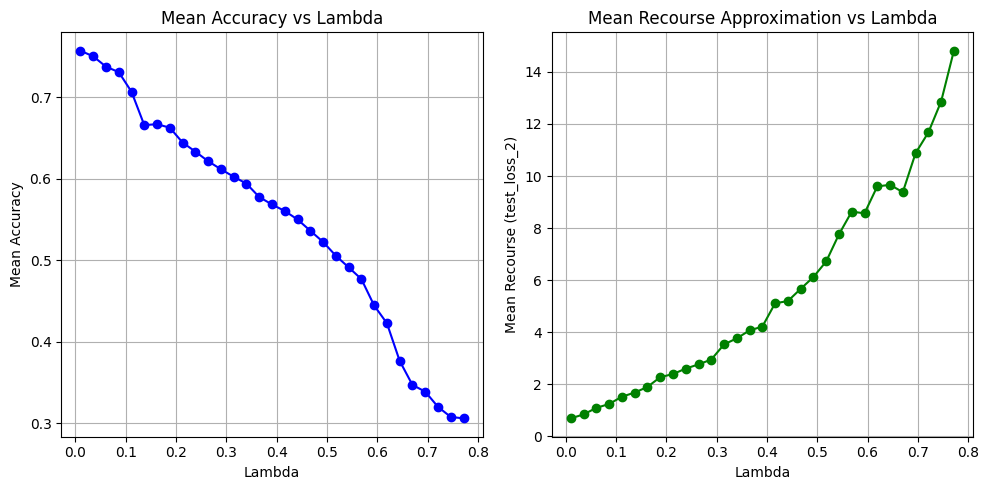

In [21]:
plt.figure(figsize=(10, 5))
lambdas = np.linspace(0.01, 1, 40)
lambdas = lambdas[:31]
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(lambdas, mean_accuracies, marker='o', color='blue')
plt.title("Mean Accuracy vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Accuracy")
plt.grid(True)

# Recourse loss plot
plt.subplot(1, 2, 2)
plt.plot(lambdas, mean_recourse_approximations, marker='o', color='green')
plt.title("Mean Recourse Approximation vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse (test_loss_2)")
plt.grid(True)

plt.tight_layout()
plt.show()


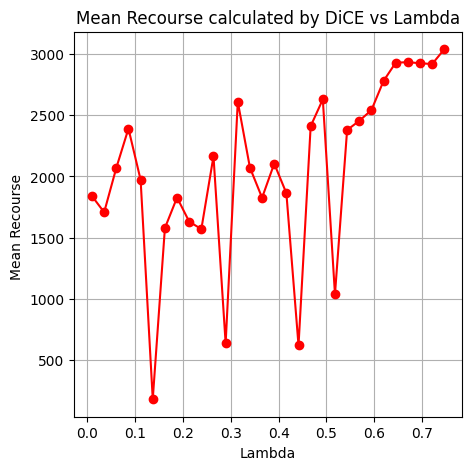

In [23]:
  ## Plotting of the mean of Recourse genereated by dice After the Training with different Lambdas
plt.figure(figsize=(5, 5))
lambdas = np.linspace(0.01, 1, 40)
lambdas = lambdas[:30]
plt.plot(lambdas, mean_recourses, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)

i think for lambda = 0.1 the results are ideal . for this lambda the mean recourse loss is 4.0515. here the recouse has doubled around 2.7 times which is a high improvement. But the accuracy took a hard hit sitting around which is not ideal Mean Accuracy: 0.7007

Why cant we use the actual recourse in the training .
Because the recourse given by dice is not differentiable.